# **FaceBook Prophet for Time Series**

**SUMMARY:**

- Import Libraries
- Load Dataset from Amazon AWS
- Exploratory Data Analysis (EDA)
- Forecast Sales With Prophet
- Fit Prophet Model
- Make an In-Sample Forecast
- Make an Out-of-Sample Forecast
- Manually Evaluate Forecast Model
- Prophet Forecasting Library

**IMPORT THE LIBRARIES**

In [407]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
pd.set_option('display.max_columns', 100)

from math import sqrt
from sklearn.metrics import mean_squared_error

#import prophet and validation libraries
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')

💾 **LOAD DATASET FROM AMAZON AWS**

In [408]:
orders = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_orders_dataset.csv"
customer = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_customers_dataset.csv"
item = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_items_dataset.csv"
products = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_products_dataset.csv"
sellers = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_sellers_dataset.csv"
order_pay = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_payments_dataset.csv"
category ="https://stack-labs-landing.s3.amazonaws.com/datasets/product_category_name_translation.csv"

💾 **CHECK OUT THE DATA**

In [409]:
df_orders = pd.read_csv(orders)
df_customers = pd.read_csv(customer)
df_item = pd.read_csv(item)
df_products = pd.read_csv(products)
df_sellers = pd.read_csv(sellers)
df_order_pay = pd.read_csv(order_pay)
df_category = pd.read_csv(category)

**MERGE DATAFRAMES**

In [410]:
df_orders = df_orders.merge(df_customers, on='customer_id', how='outer')

print(df_orders.shape)

(99441, 12)


In [411]:
# merge all the datasets in one dataset - all in one
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

print(df_train.shape)

(118434, 33)


In [412]:
#Counting number of empty rows in the df_train
df_train.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    3397
product_photos_qty               2528
product_description_lenght       2528
product_name_lenght              2528
product_category_name            2528
order_delivered_carrier_date     2074
product_width_cm                  850
product_height_cm                 850
product_length_cm                 850
product_weight_g                  850
seller_state                      830
seller_city                       830
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
seller_zip_code_prefix            830
order_approved_at                 176
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
customer_state                      0
customer_city                       0
customer_zip

# **Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?**

# **EXPLORATORY DATA ANALYSIS**

**Evolution of E-Commerce Overtime - Total Sales per day**

In [413]:
df_sale = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_sale['order_purchase_timestamp'] = pd.to_datetime(df_sale['order_purchase_timestamp'])
df_sale = df_sale.sort_values('order_purchase_timestamp')
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88789 entries, 88086 to 8468
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  88789 non-null  datetime64[ns]
 1   price                     88789 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 MB


In [414]:
df_sale.isnull().sum()

order_purchase_timestamp    0
price                       0
dtype: int64

In [415]:
df_previsao = df_sale.set_index('order_purchase_timestamp')
    
df_previsao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88789 entries, 2016-09-04 21:15:00 to 2018-10-17 17:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   88789 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [416]:
#Resample time-series data to start month.
previsao_month = df_previsao['price'].resample('MS').sum()
previsao_month.fillna(df_previsao['price'].mean(), inplace=True)

#Resample time-series data to week.
previsao_week = df_previsao['price'].resample('W-MON').sum()
previsao_week.fillna(df_previsao['price'].mean(), inplace=True)

In [417]:
previsao_month.index.sort_values()

DatetimeIndex(['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', freq='MS')

In [418]:
previsao_month.describe()

count    2.600000e+01
mean     5.465096e+05
std      3.889412e+05
min      0.000000e+00
25%      1.616670e+05
50%      5.733752e+05
75%      9.030802e+05
max      1.046128e+06
Name: price, dtype: float64

In [419]:
previsao_month[:30]

order_purchase_timestamp
2016-09-01        267.36
2016-10-01      50942.23
2016-11-01          0.00
2016-12-01         10.90
2017-01-01     128637.99
2017-02-01     260753.86
2017-03-01     396451.04
2017-04-01     391784.42
2017-05-01     545340.65
2017-06-01     453031.41
2017-07-01     533616.84
2017-08-01     601409.67
2017-09-01     662276.39
2017-10-01     693807.60
2017-11-01    1046127.84
2017-12-01     770656.15
2018-01-01     987151.41
2018-02-01     880099.79
2018-03-01    1025936.06
2018-04-01    1029472.30
2018-05-01    1032150.44
2018-06-01     909221.10
2018-07-01     925302.46
2018-08-01     884657.40
2018-09-01        145.00
2018-10-01          0.00
Freq: MS, Name: price, dtype: float64

In [420]:
previsao_month = previsao_month.replace({0.00:5.465096e+05, 10.90:50942.23,145.00:5.465096e+05})
previsao_month

order_purchase_timestamp
2016-09-01        267.36
2016-10-01      50942.23
2016-11-01     546509.60
2016-12-01      50942.23
2017-01-01     128637.99
2017-02-01     260753.86
2017-03-01     396451.04
2017-04-01     391784.42
2017-05-01     545340.65
2017-06-01     453031.41
2017-07-01     533616.84
2017-08-01     601409.67
2017-09-01     662276.39
2017-10-01     693807.60
2017-11-01    1046127.84
2017-12-01     770656.15
2018-01-01     987151.41
2018-02-01     880099.79
2018-03-01    1025936.06
2018-04-01    1029472.30
2018-05-01    1032150.44
2018-06-01     909221.10
2018-07-01     925302.46
2018-08-01     884657.40
2018-09-01     546509.60
2018-10-01     546509.60
Freq: MS, Name: price, dtype: float64

Prophet imposes the strict condition that the input columns be named ds (the time column) and y (the metric column), so let’s rename the columns in our DataFrame:

In [421]:
# Prophet requires data to be in Pandas DataFrames. Then, I summarize the shape (number of rows and columns) of the data and view the first few rows of data.
# prepare expected column names - year-month
df_ym=pd.DataFrame({'ds':previsao_month.index, 'y':previsao_month.values})
df_ym

,ds,y
0,2016-09-01,267.36
1,2016-10-01,50942.23
2,2016-11-01,546509.60
3,2016-12-01,50942.23
4,2017-01-01,128637.99
5,2017-02-01,260753.86
6,2017-03-01,396451.04
7,2017-04-01,391784.42
8,2017-05-01,545340.65
9,2017-06-01,453031.41


Note that the first column in the output is a row index and is not a part of the dataset, just a helpful tool that Pandas uses to order rows.

A time-series dataset does not make sense to us until we plot it.

Plotting a time series helps us actually see if there is a trend, a seasonal cycle, outliers, and more. It gives us a feel for the data in the year-month period.

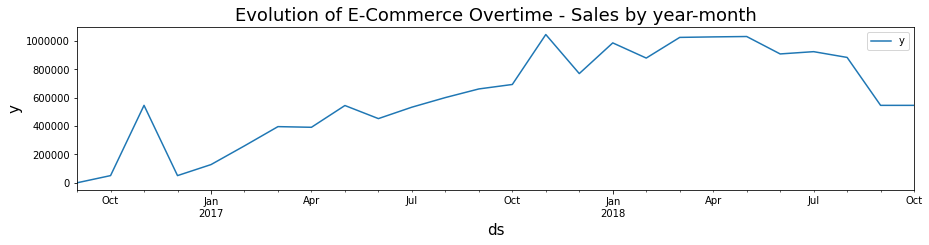

In [422]:
#Plot the original data of sales by year-month
plt.rcParams["figure.figsize"] = (15,3)
ax=df_ym.plot(x='ds',y='y')
ax.set_title("Evolution of E-Commerce Overtime - Sales by year-month", fontsize=18)
ax.set_xlabel("ds", fontsize=15)
ax.set_ylabel("y", fontsize=15)
plt.ticklabel_format(style= 'plain', axis='y');

In [423]:
df_ym['y'].min(), df_ym['y'].max()
# It is possible visualize that the maximum sale was in the month of November, the month that blackfriday occurs in Brazil.

(267.36, 1046127.8400000223)

In [424]:
previsao_week.head()

order_purchase_timestamp
2016-09-05    132.39
2016-09-12      0.00
2016-09-19    134.97
2016-09-26      0.00
2016-10-03    563.48
Freq: W-MON, Name: price, dtype: float64

In [425]:
previsao_week.describe().round(2)

count       112.00
mean     126868.31
std       95462.28
min           0.00
25%       45071.89
50%      124465.24
75%      210442.47
max      424852.90
Name: price, dtype: float64

In [426]:
previsao_week=previsao_week.iloc[:-7]
previsao_week = previsao_week.replace({0.000000: 127443.746875, 10.900000:127443.746875})
previsao_week[:20].round(2)

order_purchase_timestamp
2016-09-05       132.39
2016-09-12    127443.75
2016-09-19       134.97
2016-09-26    127443.75
2016-10-03       563.48
2016-10-10     50378.75
2016-10-17    127443.75
2016-10-24    127443.75
2016-10-31    127443.75
2016-11-07    127443.75
2016-11-14    127443.75
2016-11-21    127443.75
2016-11-28    127443.75
2016-12-05    127443.75
2016-12-12    127443.75
2016-12-19    127443.75
2016-12-26    127443.75
2017-01-02    127443.75
2017-01-09      6592.55
2017-01-16     15571.37
Freq: W-MON, Name: price, dtype: float64

In [427]:
# prepare expected column names - year-week
df_yw=pd.DataFrame({'ds':previsao_week.index, 'y':previsao_week.values})
df_yw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      105 non-null    datetime64[ns]
 1   y       105 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


A time-series dataset does not make sense to us until we plot it.

Plotting a time series helps us actually see if there is a trend, a seasonal cycle, outliers, and more. It gives us a feel for the data.

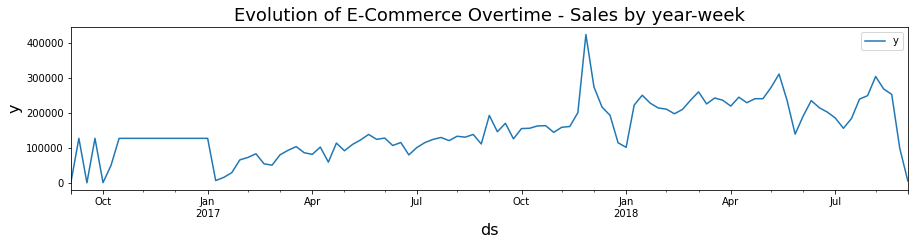

In [428]:
#Plot the Order by year-week dataset
plt.rcParams["figure.figsize"] = (15,3)
df_yw['ds']=pd.to_datetime(df_yw.ds)
ax=df_yw.plot(x='ds',y='y')
ax.set_title("Evolution of E-Commerce Overtime - Sales by year-week", fontsize=18)
ax.set_xlabel("ds", fontsize=16)
ax.set_ylabel("y", fontsize=16);

**Let's split the data into train and test to start running our model.**

In [429]:
len(df_ym)

26

In [430]:
#train test split of the year-month (ratio: 70:30)
len(df_ym)
train=df_ym[:18]
test=df_ym[18:]
train.shape, test.shape

((18, 2), (8, 2))

In [431]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(0, 17, 18, 25)

In [432]:
len(df_yw)

105

In [433]:
#train test split of the year-month (ratio: 70:30)
len(df_yw)
trainw=df_yw[:74]
testw=df_yw[74:]
trainw.shape, testw.shape

((74, 2), (31, 2))

In [434]:
# min max ds if y is max and min
print(df_yw[['ds', 'y']][df_yw.y == df_yw.y.max()], df_yw[['ds', 'y']][df_yw.y == df_yw.y.min()])

           ds         y
64 2017-11-27  424852.9           ds       y
0 2016-09-05  132.39


As expected, the week with the order maximum was in the 47th week of 2017, when is the week known as Black Friday in Brazil. The minimum number of orders was in the first week of January 2018, a hangover period for purchases that took place at the end of year.

# **Forecast e-commerce sales with Prophet**

**Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects**

In [435]:
# define and fit the model
#Tuning Facebook Prophet
m = Prophet(weekly_seasonality=True, changepoint_range=0.8,changepoint_prior_scale=0.65)
m.fit(train)

# define and fit the model
#Tuning Facebook Prophet
mw = Prophet(weekly_seasonality=True, changepoint_range=0.8,changepoint_prior_scale=0.05)
mw.fit(trainw)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.**

ds: the datestamp of the forecasted value

yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)

yhat_lower: the lower bound of our forecasts

yhat_upper: the upper bound of our forecasts

In [436]:
future=m.make_future_dataframe(periods= 26, freq='m')
forecast=m.predict(future)
# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-09-01,13067.492914,-101052.143849,115574.191644
1,2016-10-01,111871.449547,3758.097720,211914.209830
2,2016-11-01,350410.189784,244216.679070,462038.115702
3,2016-12-01,94113.185730,-3370.193687,206637.671750
4,2017-01-01,153292.703308,49222.640390,255348.737452


**The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.**

In [437]:
futurew=mw.make_future_dataframe(periods= 105, freq='w')
forecastw=mw.predict(futurew)
# display the most critical output columns from the forecast
forecastw[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-09-05,53825.073934,-9639.567071,116401.842102
1,2016-09-12,55769.556375,-3755.970365,121728.751269
2,2016-09-19,57714.038815,-9222.881162,120064.475697
3,2016-09-26,59658.521253,-4580.841939,123566.116354
4,2016-10-03,61603.003691,-3596.117800,124304.559579


Prophet also provides a convenient method to quickly plot the results of our forecasts.

Prophet plots the observed values of time series(black dots),the forecasted values(blue lines) and the uncertainty intervals of our forecasts(blue shaded region)

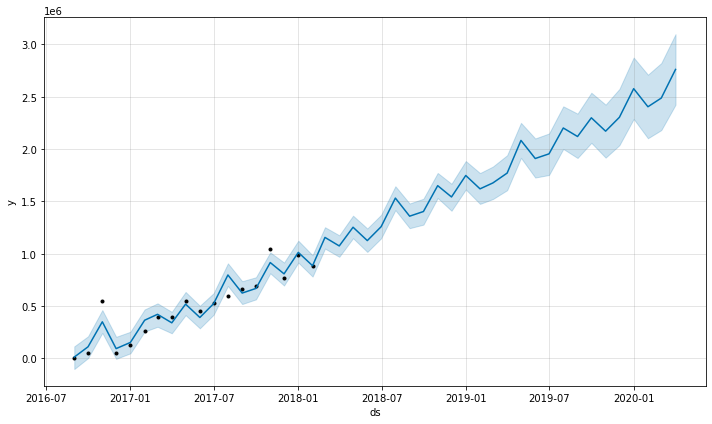

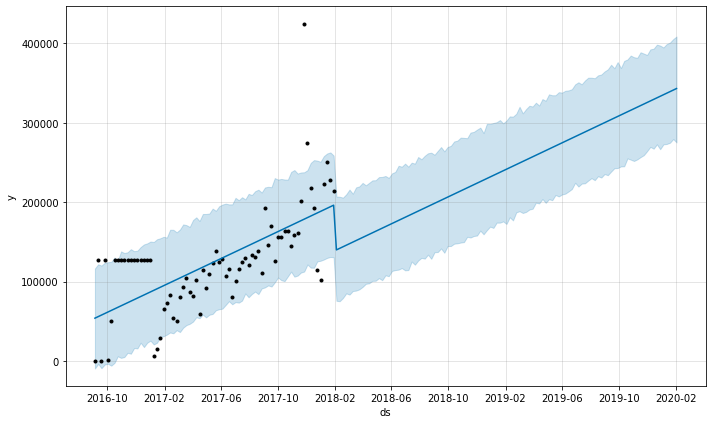

In [438]:
# plot the forecast for month-year
fig = m.plot(forecast)

# plot the forecast for month-week
fig1 = mw.plot(forecastw)

Above, it was plotted the outputs of the plotted forecast for the period year-month and year-week, respectively.


Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

**You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.**

**If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.**

In [439]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [440]:
plot_plotly(mw, forecastw)

**Cross validation - Year-Month**

In [441]:
df_cv = cross_validation(m, initial='10 days', period='360 days', horizon = '180 days').round(2)
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-08-05 00:00:00 and 2017-08-05 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-09-01,324244.77,238727.97,403950.64,662276.39,2017-08-05
1,2017-10-01,327584.46,243430.63,417528.23,693807.60,2017-08-05
2,2017-11-01,457266.31,364418.27,548255.07,1046127.84,2017-08-05
3,2017-12-01,328696.05,231953.01,423215.57,770656.15,2017-08-05
4,2018-01-01,557310.99,447881.17,660350.71,987151.41,2017-08-05


The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [442]:
df_p = performance_metrics(df_cv).round(2)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,27 days,1.142654e+11,338031.62,338031.62,0.51,0.51,0.0
1,57 days,1.341194e+11,366223.14,366223.14,0.53,0.53,0.0
2,88 days,3.467579e+11,588861.53,588861.53,0.56,0.56,0.0
3,118 days,1.953287e+11,441960.10,441960.10,0.57,0.57,0.0
4,149 days,1.847628e+11,429840.42,429840.42,0.44,0.44,0.0
5,180 days,2.401404e+11,490041.18,490041.18,0.56,0.56,0.0


Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.

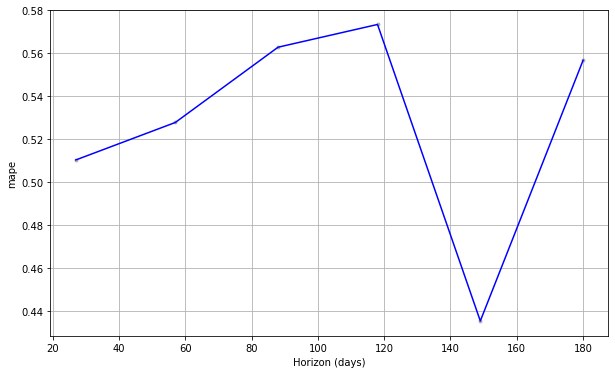

In [443]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

**Cross validation - Year-Week**

In [444]:
df_cvw = cross_validation(mw, initial='10 days', period='360 days', horizon = '180 days').round(2)
df_cvw.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-08-02 00:00:00 and 2017-08-02 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-08-07,112358.59,65832.39,161385.78,133458.56,2017-08-02
1,2017-08-14,113081.16,63912.53,161155.36,130824.37,2017-08-02
2,2017-08-21,113803.73,65937.63,162858.91,138609.53,2017-08-02
3,2017-08-28,114526.30,65479.12,166662.63,111340.71,2017-08-02
4,2017-09-04,115248.87,63218.95,163930.86,193104.23,2017-08-02


In [445]:
df_pw = performance_metrics(df_cvw).round(2)
df_pw.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,12 days,3.800151e+08,19493.98,19421.59,0.15,0.15,1.0
1,19 days,4.650746e+08,21565.59,21274.50,0.16,0.16,1.0
2,26 days,3.127378e+08,17684.40,13995.70,0.10,0.10,1.0
3,33 days,3.035803e+09,55098.12,40520.48,0.22,0.22,0.5
4,40 days,3.496662e+09,59132.58,54190.92,0.31,0.31,0.5


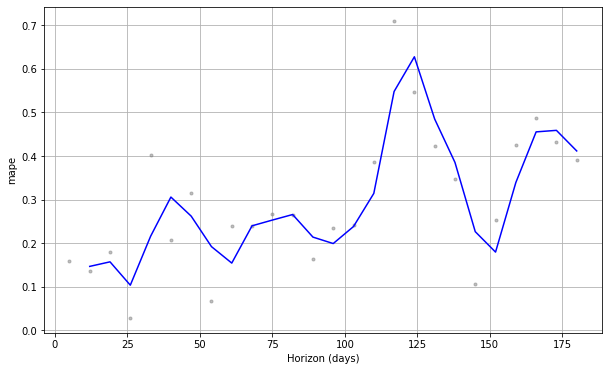

In [446]:
fig = plot_cross_validation_metric(df_cvw, metric='mape')

# **Reference**


https://facebook.github.io/prophet/